# Haplotype analysis tagging variant

Extend the haplotype analysis to the tagging variant `2R:28491424`, which tags zzb and indels in UGS.

## Input

Input files:

In [1]:
# output
outdir   = "results_TAG" # where to store output
outali   = "results_TAG" # where to store haplotype alignments
popc     = "population"

# gene of interest
chrom     = "2R"
l_nom     = "cyp6"     # nom loci
loc_start = 28480576   # start CYP6 cluster
loc_end   = 28505816   # end CYP6 cluster
loc_p4    = 28491424   # polarizing mutation: tagging varaint that we found to be linked to zzb and indels

# retain all variants between these coordinates
ret_start  = 0  
ret_end    = 100e6 # all variants

# min frq to retain minor allele
minfrq     = 0.05
# input data phase1
oc_metasam_fn = "/home/xavi/dades/Variation/phase1.AR3/samples/samples.meta.txt"
oc_hapcall_fn = "/home/xavi/dades/Variation/phase1.AR3/haplotypes/main/hdf5/ag1000g.phase1.ar3.haplotypes.2R.h5" 
oc_effcall_fn = "/home/xavi/dades/Variation/phase1.AR3/variation/zarr/ag1000g.phase1.ar3.pass/2R/" 
oc_accessi_fn = "/home/xavi/dades/Variation/phase1.AR3/accessibility/accessibility.h5"    
oc_popc       = popc
oc_popl       = ["BFS","CMS","GAS","GNS","CMS","UGS","AOM","BFM","GWA","KES"]


# extra mutations (zanzibar, duplications, etc)
kary_fn    = "data/p1_UGS_extramutations_CYP6.csv"
# gff
gffann_fn  = "data/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.9.gff3"

In [2]:
import numpy as np
import zarr
import pandas as pd
import allel
import h5py
import warnings
import scipy
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import cm
import seaborn as sns
import itertools
from mlxtend.evaluate import permutation_test
warnings.simplefilter('ignore')
import random

%run scripts_helper/hapclust.py

# load plot settings
sns.set(context="notebook",style="ticks",
        font_scale=1,font="Arial",palette="bright")

Color palette for networks (must be named!):

In [3]:
# define dictionary of pop colors
pos_colors = {
    "BFS" : "deepskyblue",
    "GAS" : "lightblue",
    "GNS" : "blue",
    "CMS" : "purple",
    "UGS" : "orange",
    "AOM" : "green",
    "BFM" : "magenta",
    "GWA" : "gray",
    "KES" : "lightgray"
}

var_colors = dict({
    -1 : "orange",
    0  : "lightgray",
    1  : "deepskyblue",
    2  : "blue",
    3  : "violet",
})


## Load data

### Phase1 variants

Population and sample data:

In [4]:
# load samples list with sample code, groupings, locations etc.
oc_samples_df   = pd.read_csv(oc_metasam_fn, sep='\t')
oc_samples_bool = (oc_samples_df[oc_popc].isin(oc_popl).values)
oc_samples      = oc_samples_df[oc_samples_bool]
oc_samples.reset_index(drop=True, inplace=True)

# indexed dictionary of populations
oc_popdict = dict()
for popi in oc_popl: 
    oc_popdict[popi]  = oc_samples[oc_samples[oc_popc] == popi].index.tolist()

# add an extra population composed of all other locations
oc_popdict["all"] = []
for popi in oc_popl:
    oc_popdict["all"] = oc_popdict["all"] + oc_popdict[popi]


# report
print("Data:")
print("* Samples     = ", oc_samples.shape[0])
print("* Populations = ", set(oc_samples[oc_popc]))
print(oc_samples.groupby(("population")).size())

Data:
* Samples     =  765
* Populations =  {'UGS', 'BFM', 'KES', 'GNS', 'GWA', 'AOM', 'BFS', 'CMS', 'GAS'}
population
AOM     60
BFM     69
BFS     81
CMS    275
GAS     56
GNS     31
GWA     46
KES     44
UGS    103
dtype: int64


Phased variants and genotypes:

In [5]:
# declare objects with variant data
#oc_hapcall   = zarr.open(oc_hapcall_fn)
oc_hapcall   = h5py.File(oc_hapcall_fn)
# variants of genotypes
print("Variants phased...")
oc_hapcall_var = oc_hapcall[chrom]["variants"]
oc_hapvars = allel.VariantChunkedTable(oc_hapcall_var,names=["POS","REF","ALT"],index="POS") 
print(oc_hapvars.shape)
# genotype data
print("Genotypes phased...")
oc_hapcall_hap = oc_hapcall[chrom]["calldata"]["genotype"]
oc_haploty     = allel.GenotypeChunkedArray(oc_hapcall_hap) 
oc_haploty     = oc_haploty.subset(sel1=oc_samples_bool)
print(oc_haploty.shape)

Variants phased...
(11332701,)
Genotypes phased...
(11332701, 765, 2)


Effects:

In [6]:
oc_effcall     = zarr.open(oc_effcall_fn)
oc_effvars     = allel.VariantChunkedTable(oc_effcall["variants"],names=[
    "POS","REF","ALT","ANN_HGVS_p","ANN_HGVS_c",
    "ANN_Annotation","ANN_AA_pos","ANN_CDS_pos",
    "ANN_Feature_ID","ANN_Gene_ID","ANN_Gene_Name"
],index="POS") 

Is effect among phased variants?

In [7]:
is_eff_in_phased = np.isin(oc_effvars["POS"], oc_hapvars["POS"])
np.unique(is_eff_in_phased,return_counts=True)

(array([False,  True]), array([ 2748269, 11332701]))

Expand phase of phased variants:

In [8]:
# recast haplotypes: drop ploidy
print("Expand phase haplotypes...")
oc_haploty_hap = oc_haploty.to_haplotypes()
print(oc_haploty_hap.shape)

Expand phase haplotypes...
(11332701, 1530)


Is variant of interest there?

In [9]:
np.unique(oc_hapvars["POS"] == loc_p4, return_counts=True)

(array([False,  True]), array([11332700,        1]))

### Sample data

Merge metadata files, with sample codes, species and populations, for variants:

In [10]:
print("Cast sample metadata...")
oc_samples = pd.DataFrame(data={
    "ox_code"    :  oc_samples["ox_code"].values.tolist() ,
    "species"    :  oc_samples["m_s"].values.astype(str).tolist(),
    "population" :  oc_samples[oc_popc].values.tolist() ,
})
print(oc_samples.shape)

# rename species...
oc_samples["species"].values[oc_samples["species"].values == "M"]   = "col"
oc_samples["species"].values[oc_samples["species"].values == "S"]   = "gam"
oc_samples["species"].values[oc_samples["species"].values == "M/S"] = "gamcol"
oc_samples["species"].values[oc_samples["species"].values == "M-S"] = "gamcol"
oc_samples["species"].values[oc_samples["species"].values == "nan"] = "gamcol"

# obtain full population & species list
oc_popl = np.unique(oc_samples["population"].values)
oc_spsl = np.unique(oc_samples["species"].values)

Cast sample metadata...
(765, 3)


Merge metadata files, with sample codes, species and populations, for expanded phased variants:

In [11]:
print("Cast sample metadata...")
oc_sampleh = pd.DataFrame(data={
    "ox_code"    :  list(itertools.chain(*[[ s + 'a', s + 'b'] for s in oc_samples["ox_code"].values.tolist()])),    # takes col from oc_samples and duplicates it, a/b
    "species"    :  list(itertools.chain(*[[ s      , s      ] for s in oc_samples["species"].values.tolist()])),
    "population" :  list(itertools.chain(*[[ s      , s      ] for s in oc_samples["population"].values.tolist()]))
})
print(oc_sampleh.shape)

Cast sample metadata...
(1530, 3)


Dictionaries of populations and species:

In [12]:
print("Population dict...")
oc_popdict = dict()
for popi in oc_popl: 
    oc_popdict[popi]  = oc_samples[oc_samples["population"] == popi].index.tolist()
oc_popdict["all"] = []
for popi in oc_popl:
    oc_popdict["all"] = oc_popdict["all"] + oc_popdict[popi]

print("Population dict phased...")
oc_popdich = dict()
for popi in oc_popl: 
    oc_popdich[popi]  = oc_sampleh[oc_sampleh["population"] == popi].index.tolist()
oc_popdich["all"] = []
for popi in oc_popl:
    oc_popdich["all"] = oc_popdich["all"] + oc_popdich[popi]

print("Species dict...")
oc_spsdict = dict()
for spsi in oc_spsl: 
    oc_spsdict[spsi]  = oc_samples[oc_samples["species"] == spsi].index.tolist()
    
print("Species dict phased...")
oc_spsdich = dict()
for spsi in oc_spsl: 
    oc_spsdich[spsi]  = oc_sampleh[oc_sampleh["species"] == spsi].index.tolist()

Population dict...
Population dict phased...
Species dict...
Species dict phased...


### Allele counts

Using both dictionaries:

In [13]:
print("Genotypes phased to allele counts (population)...")
oc_hapalco_pop = oc_haploty.count_alleles_subpops(subpops=oc_popdict)
print(oc_hapalco_pop.shape)

print("Haplotypes phased to allele counts (population)...")
oc_hapalco_hap_pop = oc_haploty_hap.count_alleles_subpops(subpops=oc_popdich)
print(oc_hapalco_hap_pop.shape)

Genotypes phased to allele counts (population)...
(11332701,)
Haplotypes phased to allele counts (population)...
(11332701,)


### Filters

#### Retain segregating and non-singletons

Define which phased variants to retain from phase1 (all other datasets will be recast to fit this):

In [14]:
# subset data: segregating alleles, biallelic and no singletons
print("Filters phased...")
oc_is_seg_h    = oc_hapalco_hap_pop["all"].is_segregating()[:] # segregating
oc_is_nosing_h = oc_hapalco_hap_pop["all"][:,:2].min(axis=1)>1 # no singletons

# subset phase2 to seg, nosing, biallelic & outgroup size
oc_hapvars_seg         = oc_hapvars.compress((oc_is_seg_h & oc_is_nosing_h))
oc_haploty_seg         = oc_haploty.compress((oc_is_seg_h & oc_is_nosing_h))
oc_hapalco_pop_seg     = oc_hapalco_pop.compress((oc_is_seg_h & oc_is_nosing_h))
oc_haploty_hap_seg     = oc_haploty_hap.compress((oc_is_seg_h & oc_is_nosing_h))
oc_hapalco_hap_pop_seg = oc_hapalco_hap_pop.compress((oc_is_seg_h & oc_is_nosing_h))

# report
print(oc_haploty_seg.shape,"/", oc_haploty.shape)

Filters phased...
(7629561, 765, 2) / (11332701, 765, 2)


Same for variant effects:

In [15]:
oc_effvars_seg_pos = oc_effvars["POS"][:][is_eff_in_phased].compress((oc_is_seg_h & oc_is_nosing_h))
oc_effvars_seg_ref = oc_effvars["REF"][:][is_eff_in_phased].compress((oc_is_seg_h & oc_is_nosing_h))
oc_effvars_seg_alt = oc_effvars["ALT"][:][is_eff_in_phased].compress((oc_is_seg_h & oc_is_nosing_h))
oc_effvars_seg_gen = oc_effvars["ANN_Feature_ID"][:][is_eff_in_phased].compress((oc_is_seg_h & oc_is_nosing_h))
oc_effvars_seg_pep = oc_effvars["ANN_HGVS_p"][:][is_eff_in_phased].compress((oc_is_seg_h & oc_is_nosing_h))
oc_effvars_seg_cds = oc_effvars["ANN_HGVS_c"][:][is_eff_in_phased].compress((oc_is_seg_h & oc_is_nosing_h))
oc_effvars_seg_typ = oc_effvars["ANN_Annotation"][:][is_eff_in_phased].compress((oc_is_seg_h & oc_is_nosing_h))
oc_effvars_seg_pep.shape

(7629561,)

Create array of printable variant names:

In [16]:
oc_snpname_seg = np.array(
    [chrom+":"+x1+" "+x2+" "+x3 for x1,x2,x3 in zip(
        oc_effvars_seg_pos.astype(str),
        oc_effvars_seg_gen.astype(str),
        oc_effvars_seg_pep.astype(str),
    )]
)

#### Retain min frequency and location

Is variant above certain minimum frequency? 

In [17]:
# allele counts table per pop
co_major = pd.DataFrame() 
co_minor = pd.DataFrame()
fq_minor = pd.DataFrame()
for popi in oc_popl: 
    co_major[popi] = oc_hapalco_pop_seg[popi][:,0]
    co_minor[popi] = oc_hapalco_pop_seg[popi][:,1]
    fq_minor[popi] = oc_hapalco_pop_seg[popi][:,1] / oc_hapalco_pop_seg[popi][:,0:2].sum(axis=1)
co_major["all"] = co_major.sum(axis=1)
co_minor["all"] = co_minor.sum(axis=1)
fq_minor["all"] = co_minor.sum(axis=1) / (co_minor.sum(axis=1)+co_major.sum(axis=1))

# subset data: keep variants with at least 5% freq in at least one pop
is_minfq  = np.logical_and(fq_minor.max(axis=1) > minfrq, fq_minor.min(axis=1) < 1-minfrq)

Is variant in the loci of interest? (useful for reporting)

In [18]:
is_in_loci = np.logical_and(oc_hapvars_seg["POS"] >= loc_start, oc_hapvars_seg["POS"] <= loc_end)

Is variant non syn?

In [19]:
is_nonsyn  = oc_effvars_seg_typ == "missense_variant"

Should variant frequency be reported? (in loci, nonsyn, min freq, segregating, non singleton):

In [20]:
# report
is_report  = (is_in_loci & is_minfq & is_nonsyn)
print("in loci:                    ",sum(is_in_loci))
print("in loci, nonsyn and min frq:",sum(is_report))

in loci:                     2398
in loci, nonsyn and min frq: 208


Print table with variants, effects and frequencies per population:

In [21]:
# print table
fq_repor = pd.DataFrame(data={
    "chr"      : [chrom] * co_minor[is_in_loci].shape[0],
    "POS"      : oc_hapvars_seg["POS"].subset(sel0=is_in_loci)[:].astype(str),
    "REF"      : oc_hapvars_seg["REF"].subset(sel0=is_in_loci)[:].astype(str),
    "ALT"      : oc_hapvars_seg["ALT"].subset(sel0=is_in_loci)[:].astype(str),
    "is_nonsyn": is_nonsyn[is_in_loci],
    "gene_eff" : oc_effvars_seg_gen[is_in_loci].astype(str),
    "PEP_eff"  : oc_effvars_seg_pep[is_in_loci].astype(str),
    "CDS_eff"  : oc_effvars_seg_cds[is_in_loci].astype(str),
},
columns=["chr","POS","REF","ALT","gene_eff","PEP_eff","CDS_eff","is_nonsyn"]
)
fq_repor = pd.concat([fq_repor,fq_minor[is_in_loci].reset_index()],axis=1)
fq_repor.to_csv("%s/allele_fq.csv" % (outdir),sep="\t",index=False)

Print table with genotypes of nonsyn variants, per sample:

In [22]:
# dataframe with pops
gt_repor = pd.DataFrame(data={
    "ox_code"    : oc_samples["ox_code"],
    "population" : oc_samples["population"],
    "species"    : oc_samples["species"],
}
)

# retrieve 012 genotypes for report
gt_gtysa = pd.DataFrame(np.transpose(oc_haploty_seg.subset(sel0=is_report).to_n_alt(fill=-1)))
gt_gtysa.columns = oc_snpname_seg[is_report]

# print
gt_repor = pd.concat([gt_repor, gt_gtysa],axis=1)
gt_repor.to_csv("%s/allele_genotypes.csv" % (outdir),sep="\t",index=False)

### Other data

Accessibility:

In [23]:
# Accessibility
print("Load accessibility array...")
accessi_df  = h5py.File(oc_accessi_fn,mode="r")
accessi_arr = accessi_df[chrom]["is_accessible"][:]

Load accessibility array...


Gene annotations GFF:

In [24]:
# import gff
def geneset_gff(geneset):
    items = []
    for n in geneset.dtype.names:
        v = geneset[n]
        if v.dtype.kind == 'S':
            v = v.astype('U')
        items.append((n, v))
    return pd.DataFrame.from_items(items)
%run scripts_helper/plot_transcripts.py

geneset = allel.FeatureTable.from_gff3(gffann_fn,attributes=['ID', 'Parent'])
geneset = geneset_gff(geneset)


In [25]:
geneset[geneset["Parent"] == "AGAP002867"]

,seqid,source,type,start,end,score,strand,phase,ID,Parent
69657,2R,VectorBase,mRNA,28497087,28498674,-1.0,-,-1,AGAP002867-RA,AGAP002867


## Haplotype networks

Visualize haplotype similarity with **haplotype networks**, built from phased variants around the `I236M CYP6P4` mutation.

In [26]:
# input hap networks
loc_vari = loc_p4     # variable to use as focus of hap networks -> position in the genome
loc_varn = "centre"   # name it

# parameters hap networks
fbp_hap  = 2e4     # num bp to retain around variant of interest (allele) to define core haplotyes, CC uses 6kbp
max_dist = 5       # dist that breaks edges; default is 5; CC uses 2 -> if network method is MJN, then it doesn't work for max_dist>1!!!!
max_alle = 1       # indirect variant breaks
net_meth = "msn"   # can be: minimum_spanning_network msn ; minimum_spanning_tree mst ; median_joining_network mjt
min_fq_h = 0.01    # min freq of the haplotype cluster, below that the component will be excluded from plots
min_fc_h = int(min_fq_h*oc_haploty_hap_seg.shape[1])

loc_vari_bool = np.any(oc_hapvars["POS"]   == loc_vari)
loc_vari_ix   = np.where(oc_hapvars["POS"] == loc_vari)[0][0]

# report
print("Is %i %s in phased array? %s: index %i " % (loc_vari,loc_varn,loc_vari_bool,loc_vari_ix))

Is 28491424 centre in phased array? True: index 6808210 


Subset haplotypes to focus on variants around focal locus:

In [27]:
# subset hap arrays to fit loci of interest (loci centre +/- fbp_hap)
loc_pos_ix = allel.SortedIndex(oc_hapvars_seg['POS'])
loc_pos_rn = loc_pos_ix.locate_range(loc_vari-fbp_hap,loc_vari+fbp_hap)

# snp name
oc_snpname_seg_mis = oc_snpname_seg
loc_hap    = oc_haploty_hap_seg[loc_pos_rn]
loc_snpnom = oc_effvars_seg_pep[loc_pos_rn]

# report
print("Phased variants and samples around %s:" % loc_vari,loc_hap.shape)

# color arrays
loc_colpos = np.array([pos_colors[p] for p in oc_sampleh["population"].values])
loc_gty_A  = oc_haploty_hap_seg[ np.where(loc_pos_ix==loc_vari)[0][0] ]       # genotype of A296G
loc_gty_T  = loc_gty_A
loc_colvar = np.array([var_colors[p] for p in loc_gty_T])

Phased variants and samples around 28491424: (4305, 1530)


Build **hap networks colored by population**, and store which samples are in which component:

In [28]:
loc_graph, loc_distinct_sets, loc_components = graph_haplotype_network(
    h=loc_hap,
    max_dist=max_dist,   
    max_allele=max_alle, # for MJN only; default is 3
    show_node_labels=min_fc_h,
    distance_metric='hamming',network_method=net_meth,
    hap_colors=loc_colpos,variant_labels=loc_snpnom,
    return_components=True,show_singletons=False)

num_components = loc_components.shape[0]

# plot pdf
loc_graph.format = 'pdf'
loc_graph.attr(label='\n\n%s %s %s:%i\n%i haps clustered into %i clusters with %s maxdist %i, from %i phased vars located +/- %i bp' % (l_nom,loc_varn,chrom,loc_vari,loc_hap.shape[1],num_components,net_meth,max_dist,loc_hap.shape[0],fbp_hap))
fn = "%s/hapnet_%s_var_%s_%s-pop" % (outdir,net_meth,loc_vari,loc_varn)
loc_graph.render(fn,cleanup=True)

'results_TAG/hapnet_msn_var_28491424_centre-pop.pdf'

In [29]:
# map hap clusters with REF alleles to actual lists of populations
# BEWARE: identify_components fails if max_dist > 1 in MJN
def identify_components(h_distinct_sets, components):
    """This function is designed to collect all indices for original haplotypes 
    within each connected component. I.e., it finds clusters from the network."""
    clusters = []
    for c in np.unique(components):
        cluster = set()
        for i in np.nonzero(components == c)[0]:
            cluster |= h_distinct_sets[i]
        clusters.append(sorted(cluster))
    return clusters

loc_components_id      = identify_components(loc_distinct_sets, loc_components) 
loc_components_id_hapi = []
loc_components_id_clui = []
loc_components_id_dati = pd.DataFrame()
for n,i in enumerate(loc_components_id):
    loc_components_id_hapi = loc_components_id_hapi + loc_components_id[n]
    loc_components_id_clui = loc_components_id_clui + list([n]*len(loc_components_id[n]))

loc_components_id_dati["hap_index"]   = loc_components_id_hapi
loc_components_id_dati["hap_cluster"] = loc_components_id_clui
loc_components_id_dati                = loc_components_id_dati.sort_values(by="hap_index")
loc_components_id_dati                = loc_components_id_dati.set_index(keys="hap_index")
loc_components_id_dati["pop"]         = oc_sampleh["population"].values
loc_components_id_dati["hap_id"]      = oc_sampleh["ox_code"].values

# report
print("total haps:",loc_hap.shape[1])
print("num haps per cluster (only clusters n>=%i):" % min_fc_h)
print(loc_components_id_dati.groupby(("hap_cluster")).size()[loc_components_id_dati.groupby(("hap_cluster")).size()>=min_fc_h])

total haps: 1530
num haps per cluster (only clusters n>=15):
hap_cluster
0       59
1       38
2       41
26      27
36      42
98     119
99      34
215     26
216     26
218     21
221     91
223    156
226     24
473     35
476     27
522     24
dtype: int64


Which clusters should we print? Those with frequency > 1% in the cohort (`min_fc_h` and `min_fq_h` variables, defined above):

In [30]:
min_cluster_size = min_fc_h
    
# select clusters
clu_list_ids     = np.unique(loc_components_id_dati["hap_cluster"],return_counts=True)[0]
clu_list_cou     = np.unique(loc_components_id_dati["hap_cluster"],return_counts=True)[1]
clu_list_ids_fil = clu_list_ids[clu_list_cou >= min_cluster_size]
clu_list_cou_fil = clu_list_cou[clu_list_cou >= min_cluster_size]
loc_printhap     = np.isin(loc_components_id_dati["hap_cluster"].values, clu_list_ids_fil)

print(loc_varn,loc_vari,"print clusters:",clu_list_ids_fil,"\t\tsize of clusters: ",clu_list_cou_fil)
print(loc_varn,loc_vari,"print clusters total size:",sum(loc_printhap),"/",len(loc_printhap))

centre 28491424 print clusters: [  0   1   2  26  36  98  99 215 216 218 221 223 226 473 476 522] 		size of clusters:  [ 59  38  41  27  42 119  34  26  26  21  91 156  24  35  27  24]
centre 28491424 print clusters total size: 790 / 1530


In [31]:
loc_graph, loc_distinct_sets, loc_components = graph_haplotype_network(
    h=loc_hap.subset(sel1=loc_printhap),
    max_dist=max_dist,   
    max_allele=max_alle, # for MJN only; default is 3
    show_node_labels=100,
    distance_metric='hamming',network_method=net_meth,
    hap_colors=loc_colpos[loc_printhap],variant_labels=loc_snpnom,
    return_components=True,show_singletons=False)

num_components = loc_components.shape[0]

# plot pdf
loc_graph.format = 'pdf'
loc_graph.attr(label='\n\n%s %s %s:%i\n%i haps clustered into %i clusters with %s maxdist %i, from %i phased vars located +/- %i bp' % (l_nom,loc_varn,chrom,loc_vari,loc_hap.shape[1],num_components,net_meth,max_dist,loc_hap.shape[0],fbp_hap))
fn = "%s/hapnet_%s_var_%s_%s-pop_minfq" % (outdir,net_meth,loc_vari,loc_varn)
loc_graph.render(fn,cleanup=True)

'results_TAG/hapnet_msn_var_28491424_centre-pop_minfq.pdf'

Plot haplotype networks colored by genotype in CYP6P4-I236M:

* 236I (wt) is gray (0)
* 236M is light blue (1)
* missing genotype is orange (-1)

In [32]:
loc_components_id_dati["CYP6P4_nonsyn"] = loc_gty_T

In [33]:
loc_graph, loc_distinct_sets, loc_components = graph_haplotype_network(
    h=loc_hap.subset(sel1=loc_printhap),
    max_dist=max_dist,   
    max_allele=max_alle, # for MJN only; default is 3
    show_node_labels=100,
    distance_metric='hamming',network_method=net_meth,
    hap_colors=loc_colvar[loc_printhap],variant_labels=loc_snpnom,
    return_components=True,show_singletons=False)

num_components = loc_components.shape[0]

# plot pdf
loc_graph.format = 'pdf'
loc_graph.attr(label='\n\n%s %s %s:%i\n%i haps clustered into %i clusters with %s maxdist %i, from %i phased vars located +/- %i bp' % (l_nom,loc_varn,chrom,loc_vari,loc_hap.shape[1],num_components,net_meth,max_dist,loc_hap.shape[0],fbp_hap))
fn = "%s/hapnet_%s_var_%s_%s-gty_minfq" % (outdir,net_meth,loc_vari,loc_varn)
loc_graph.render(fn,cleanup=True)

'results_TAG/hapnet_msn_var_28491424_centre-gty_minfq.pdf'

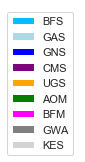

In [34]:
# plot color legend
# WARNING: colors might be slightly different because matplotlib and graphviz parse them differently
pdf = PdfPages("%s/hapnet_legend.pdf" % (outdir))
fig,ax = plt.subplots(figsize=(1,1))
ax.set_axis_off()
custom_lines = [mpatches.Patch(facecolor=pos_colors[coli]) for coli in pos_colors.keys()]
plt.legend(labels=pos_colors.keys(),handles=custom_lines)
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

Now, output table with clusters, for posterity:

In [35]:
loc_components_id_dati.to_csv("%s/hapnet_result.csv" % (outdir),sep="\t",index=False)

### Distribution of populations per haplotype

Barplots:

In [36]:
def annotate_barplot(ax,color="k", labformat = "{:.2f}"):
    rects = ax.patches
    for rect in rects:
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2
        space   = 5
        ha      = 'left'
        label   = labformat.format(x_value) ## annotates bars with height labels, with 2 decimal points
        plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", va='center', ha=ha, color=color)


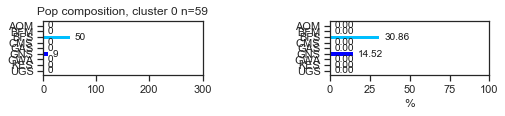

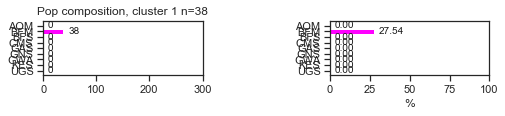

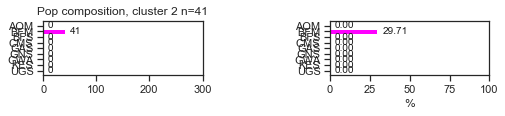

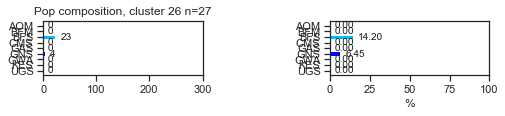

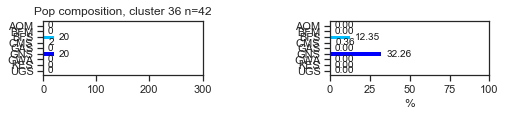

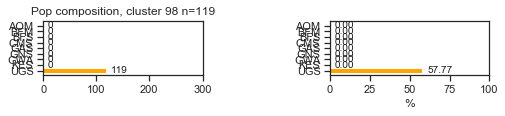

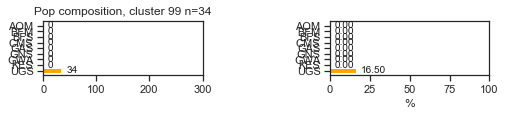

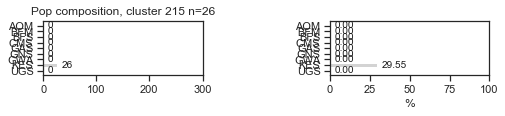

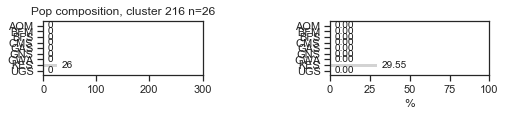

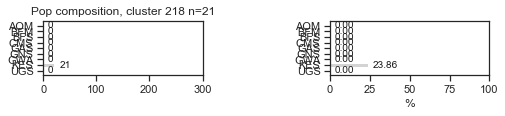

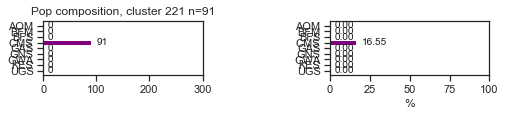

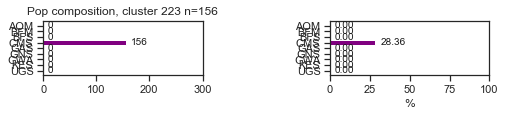

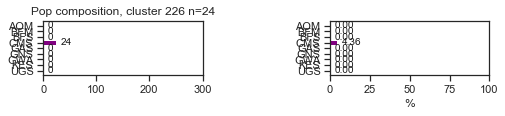

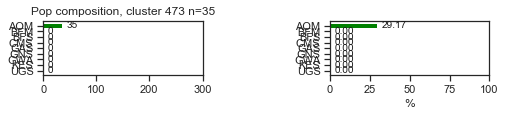

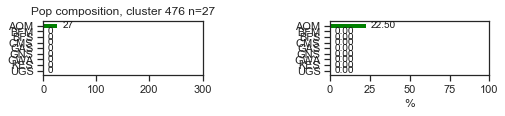

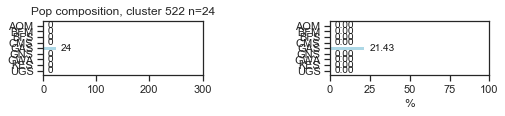

In [37]:
pdf = PdfPages("%s/hapnet_popcomp_perhap.pdf" % (outdir))

for i,clui in enumerate(clu_list_ids_fil):

    fig = plt.figure(figsize=(8,1))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=None)
    
    # and now: some barplots with pop composition of each cluster
    ax1 = plt.subplot(1, 2, 1)
    hap_labl = "Pop composition, cluster "+str(clui)+" n="+str(clu_list_cou_fil[i])
    hap_clui = loc_components_id_dati["hap_id"][loc_components_id_dati["hap_cluster"] == int(clui)]
    hap_popi = loc_components_id_dati["pop"][loc_components_id_dati["hap_cluster"] == int(clui)]
    pie_labels = oc_popl
    pie_counts = [len(np.where(hap_popi==popi)[0]) for popi in pie_labels]
    pie_colors = [pos_colors[popi] for popi in pie_labels]
    plt.barh(width=pie_counts[::-1],y=pie_labels[::-1],color=pie_colors[::-1])
    ax1.set_xlim(0,300)
    annotate_barplot(ax=ax1, labformat="{:.0f}")
    plt.title(hap_labl)

    # and next: some barplots with pop % of each cluster
    ax2 = plt.subplot(1, 2, 2)
    hap_labl = "% of haps from each pop in cluster"
    pie_coutot = oc_sampleh.groupby("population").size()
    pie_coutot = pie_coutot[pie_labels]
    pie_fracti = pie_counts / pie_coutot * 100
    plt.barh(width=pie_fracti[::-1],y=pie_labels[::-1],color=pie_colors[::-1])
    annotate_barplot(ax=ax2, labformat="{:.2f}")
    ax2.set_xlabel("%")
    ax2.set_xlim(0,100)

    pdf.savefig(fig,bbox_inches='tight')
    
pdf.close()

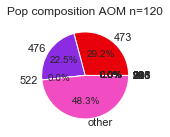

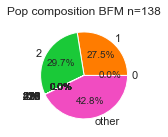

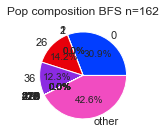

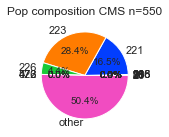

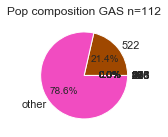

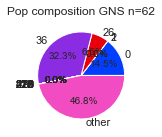

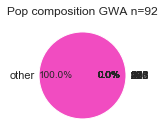

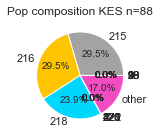

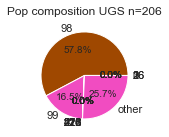

In [38]:
pdf = PdfPages("%s/hapnet_popcomp_perpop.pdf" % (outdir))

for popi in oc_popl:
    
    fig = plt.figure(figsize=(2,2))
    
    ax2 = plt.subplot(1, 1, 1)

    hap_popi = loc_components_id_dati["hap_cluster"][loc_components_id_dati["pop"] == popi]
    pie_coun = [sum(hap_popi == i) for i in clu_list_ids_fil]
    pie_coub = np.append(pie_coun, len(hap_popi)-sum(pie_coun))
    pie_labb = np.append(clu_list_ids_fil, "other")
    pie_titl = "Pop composition "+popi+" n="+str(len(hap_popi))
    ax2.pie(pie_coub,labels=pie_labb, autopct="%1.1f%%")
    plt.title(pie_titl)
    pdf.savefig(fig,bbox_inches='tight')
    
pdf.close()